# Audiobook Customer Data

The data is from an audiobook company that collected all the attributes from it's customer base over a period of 2 years. A further 6 months of data was collected to check if a customer would convert or not. 

In this case, a conversion is measured by a new purchase of audiobook.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.model_selection 
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier


#To import file from the local drive
from google.colab import files
import io

#Prompts to upload the required file
uploaded = files.upload()

Saving Audiobooks_data.csv to Audiobooks_data.csv


In [2]:
audiobook_df = pd.read_csv(io.BytesIO(uploaded['Audiobooks_data.csv']))

The missing values have been preprocessed, i.e all of them have been imputed with averages.

In [3]:
print(audiobook_df.shape)

#Snippet of the dataset
audiobook_df.head()

(14084, 12)


,ID,Book length(mins) overall,Book length(mins) avg,Price_avg,Price_overall,Review,Review 10/10,Completion,Minutes listened,Support requests,Last visited minus purchasse date,Target
0,994,1620.0,1620,19.73,7.00,1,10.00,0.99,1603.8,5,92,0
1,1143,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0,0
2,2059,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388,0
3,2882,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129,0
4,3342,2160.0,2160,5.33,5.33,0,8.91,0.22,475.2,0,361,0


We have 11 independant features. The Target variable is what needs to be predicted by our model.

## Balancing the dataset

Our data has 85% of target class 0 and only 15% of target class 1. This is highly imbalanced.

In [4]:
audiobook_df['Target'].value_counts()

0    11847
1     2237
Name: Target, dtype: int64

In [5]:
# Removing all target values that are 0 such that the number of 0s and 1s are equal.
target_value_1 = 2237
target_indices_to_remove = [] #indices of the target values that will be removed.
target_0_counter = 0          #Set the counter to 0 initially.

for i in range(audiobook_df.shape[0]):
  if audiobook_df['Target'][i] == 0:
    target_0_counter += 1
    if target_0_counter > target_value_1:
      target_indices_to_remove.append(i)

print(f'Number of rows to be removed : {len(target_indices_to_remove)}')



Number of rows to be removed : 9610


In [6]:
#Drop the list of indices returned previously.
audiobook_balanced_df = audiobook_df.drop(audiobook_df.index[target_indices_to_remove],axis=0)
audiobook_balanced_df.reset_index(drop=True)
audiobook_balanced_df.shape

(4474, 12)

In [7]:
audiobook_balanced_df['Target'].value_counts()

1    2237
0    2237
Name: Target, dtype: int64

The skewed ratio has been corrected to 50% each class.

## Feature selection

We can keep all of the features except for the ID column.

In [8]:
audiobook_balanced_df.drop(['ID'],axis=1,inplace=True)

## Shuffle the data

In [9]:
# Let's shuffle the dataset 
audiobook_balanced_shuffled = audiobook_balanced_df.sample(frac=1)

## Standardize the data

In [10]:
# Before standardizing, let us seperate the i/p variables and the target variable.
targets = audiobook_balanced_shuffled.iloc[:,-1]
targets.shape

(4474,)

In [11]:
audiobook_balanced_shuffled.drop(['Target'],axis=1,inplace=True)
audiobook_balanced_shuffled.shape

(4474, 10)

In [12]:
scaler = preprocessing.StandardScaler()

audiobook_balanced_shuffledScaled = scaler.fit_transform(audiobook_balanced_shuffled)

## Train Test split

Let's create a train,test and validation split in the ration 80:10:10.

In [13]:
#Create train and test splits
X_train,X_test,Y_train,Y_test = sklearn.model_selection.train_test_split(audiobook_balanced_shuffledScaled,targets,test_size=0.2, random_state=1)

#Create another validation set from the test set.
X_test,X_val,Y_test,Y_val = sklearn.model_selection.train_test_split(X_test,Y_test,test_size=0.5, random_state=1)

In [14]:
print(f'Training set size :{X_train.shape[0]},\n Value counts : {Y_train.value_counts()}\n')
print(f'Test set size : {X_test.shape[0]},\n Value counts : {Y_test.value_counts()}\n')
print(f'Validation set size : {X_val.shape[0]},\n Value counts : {Y_val.value_counts()}')

Training set size :3579,
 Value counts : 1    1790
0    1789
Name: Target, dtype: int64

Test set size : 447,
 Value counts : 0    227
1    220
Name: Target, dtype: int64

Validation set size : 448,
 Value counts : 1    227
0    221
Name: Target, dtype: int64


## Save the datasets in npz format

In [15]:
np.savez('Audiobooks_data_train',ip = X_train, op = Y_train)
np.savez('Audiobooks_data_test',ip = X_test, op = Y_test)
np.savez('Audiobooks_data_validation',ip = X_val, op = Y_val)

In [16]:
#Training variables
data = np.load('Audiobooks_data_train.npz')
train_inputs = data['ip'].astype(np.float)
train_outputs = data['op'].astype(np.int)

#Validationn variables
data = np.load('Audiobooks_data_validation.npz')
validation_inputs = data['ip'].astype(np.float)
validation_outputs = data['op'].astype(np.int)

#Testing variables
data = np.load('Audiobooks_data_test.npz')
test_inputs = data['ip'].astype(np.float)
test_outputs = data['op'].astype(np.int)

## Model

In [31]:
input_size = 10
hidden_layer_size = 200
output_size = 2

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(output_size,activation='softmax')
])
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

batch_size = 100
max_epochs = 100

model.fit(train_inputs,train_outputs,validation_data=(validation_inputs,validation_outputs),batch_size=batch_size, epochs=max_epochs)

Epoch 1/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4871 - accuracy: 0.7323 - val_loss: 0.4065 - val_accuracy: 0.7701
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 0.3856 - accuracy: 0.7868 - val_loss: 0.4122 - val_accuracy: 0.7656
Epoch 3/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3623 - accuracy: 0.8039 - val_loss: 0.3724 - val_accuracy: 0.7946
Epoch 4/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3492 - accuracy: 0.8061 - val_loss: 0.4138 - val_accuracy: 0.7768
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.3462 - accuracy: 0.8167 - val_loss: 0.4036 - val_accuracy: 0.7723
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.3393 - accuracy: 0.8220 - val_loss: 0.3677 - val_accuracy: 0.8058
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.3415 - accuracy: 0.8175 - val_loss: 0.3604 - val_accuracy: 0.7812
Epoch 8/100
3

Initial training accuracy - 84%
Validation accuracy - 80.3%

### Grid search Batch size and Epochs

In [18]:
input_size = 10
hidden_layer_size = 200
output_size = 2

def CreateModel():
  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(output_size,activation='softmax')
  ])
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

In [19]:
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=CreateModel, verbose=0)

In [20]:
batch_size = [60, 80, 100,150,200]
epochs = [50, 100,150,200]
param_grid = dict(batch_size=batch_size, epochs=epochs)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_inputs,train_outputs,validation_data=(validation_inputs,validation_outputs),callbacks=early_stopping)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.814753 using {'batch_size': 200, 'epochs': 150}
0.789327 (0.002091) with: {'batch_size': 60, 'epochs': 50}
0.801621 (0.007254) with: {'batch_size': 60, 'epochs': 100}
0.804135 (0.014874) with: {'batch_size': 60, 'epochs': 150}
0.797150 (0.008298) with: {'batch_size': 60, 'epochs': 200}
0.813356 (0.015186) with: {'batch_size': 80, 'epochs': 50}
0.776474 (0.011127) with: {'batch_size': 80, 'epochs': 100}
0.802459 (0.015062) with: {'batch_size': 80, 'epochs': 150}
0.797150 (0.010334) with: {'batch_size': 80, 'epochs': 200}
0.789885 (0.015186) with: {'batch_size': 100, 'epochs': 50}
0.796032 (0.005532) with: {'batch_size': 100, 'epochs': 100}
0.803576 (0.023233) with: {'batch_size': 100, 'epochs': 150}
0.800503 (0.009655) with: {'batch_size': 100, 'epochs': 200}
0.811959 (0.010296) with: {'batch_size': 150, 'epochs': 50}
0.810282 (0.006855) with: {'batch_size': 150, 'epochs': 100}
0.792400 (0.004125) with: {'batch_size': 150, 'epochs': 150}
0.810562 (0.013200) with: {'batch_size': 

Best: 0.814753 using {'batch_size': 200, 'epochs': 150}

### Grid Search Optimizer

In [25]:
input_size = 10
hidden_layer_size = 200
output_size = 2

def CreateModel(optimizer = 'adam'):
  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(output_size,activation='softmax')
  ])
  model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

In [24]:
seed = 7
np.random.seed(seed)

# create model using {'batch_size': 200, 'epochs': 150}
model = KerasClassifier(build_fn=CreateModel, batch_size = 200, epochs = 150, verbose=0)


#Create dictionary of optimizers.
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer = optimizer)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_inputs,train_outputs,validation_data=(validation_inputs,validation_outputs),callbacks=early_stopping)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.815870 using {'optimizer': 'Adam'}
0.801341 (0.002983) with: {'optimizer': 'SGD'}
0.806370 (0.026718) with: {'optimizer': 'RMSprop'}
0.778430 (0.003769) with: {'optimizer': 'Adagrad'}
0.609109 (0.036088) with: {'optimizer': 'Adadelta'}
0.815870 (0.009292) with: {'optimizer': 'Adam'}
0.811400 (0.010220) with: {'optimizer': 'Adamax'}
0.789327 (0.018584) with: {'optimizer': 'Nadam'}


{'optimizer': 'Adam'}

## Learning Rate

In [26]:
input_size = 10
hidden_layer_size = 200
output_size = 2

def CreateModel(learn_rate=0.1):
  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                               tf.keras.layers.Dense(output_size,activation='softmax')
  ])
  #optimizer = tf.keras.optimizers.Adamax(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adamax')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
  model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

In [27]:
seed = 7
np.random.seed(seed)

# create model using {'batch_size': 200, 'epochs': 150}
model = KerasClassifier(build_fn=CreateModel, batch_size = 200, epochs = 150, verbose=0)


#Create dictionary of Learning rate and momentum parameter beta.
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate = learn_rate)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_inputs,train_outputs,validation_data=(validation_inputs,validation_outputs),callbacks=early_stopping)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.814753 using {'learn_rate': 0.2}
0.800503 (0.004791) with: {'learn_rate': 0.001}
0.804973 (0.007932) with: {'learn_rate': 0.01}
0.793797 (0.022029) with: {'learn_rate': 0.1}
0.814753 (0.008410) with: {'learn_rate': 0.2}
0.798826 (0.025489) with: {'learn_rate': 0.3}


Best: 0.814753 using {'learn_rate': 0.2}
Subsequent tests proved 0.2 was suboptimal. Hence we will use a learning rate of 0.001.
## Testing all above Hyperparameters

In [44]:
from keras.optimizers import Adam
input_size = 10
hidden_layer_size = 200
output_size = 2

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(output_size,activation='softmax')
])
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, name='Adam')
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

batch_size = 150
max_epochs = 200

history = model.fit(train_inputs,train_outputs,validation_data=(validation_inputs,validation_outputs),batch_size=batch_size, epochs=max_epochs,verbose=0)

In [98]:
print(f"Training accuracy : {round(history.history['accuracy'][199] * 100,2)}%")
print(f"Validaton accuracy : {round(history.history['val_accuracy'][199] * 100,2)}% \n")
print(f"Training loss : {round(history.history['loss'][199],2)}")
print(f"Validation loss : {round(history.history['val_loss'][199],2)}")


Training accuracy : 84.6%
Validaton accuracy : 81.03% 

Training loss : 0.28
Validation loss : 0.44


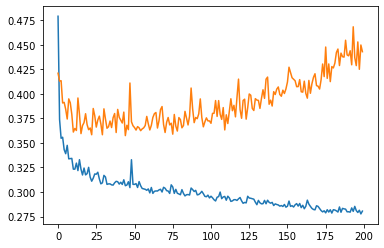

In [54]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Validation')

From the above graph, it's apparent that we need to set an early stopping mechanism to prevent over fitting.

In [87]:
#Using early stopping, train the same model.
input_size = 10
hidden_layer_size = 200
output_size = 2

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
                            tf.keras.layers.Dense(output_size,activation='softmax')
])
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, name='Adam')
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

batch_size = 150
max_epochs = 200
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history2 = model.fit(train_inputs,train_outputs,validation_data=(validation_inputs,validation_outputs),batch_size=batch_size, epochs=max_epochs,\
          verbose=0,callbacks=early_stopping)


In [100]:
print(f"Training accuracy : {round(history2.history['accuracy'][19] * 100,2)}%")
print(f"Validaton accuracy : {round(history2.history['val_accuracy'][19] * 100,2)}% \n")
print(f"Training loss : {round(history2.history['loss'][19],2)}")
print(f"Validation loss : {round(history2.history['val_loss'][19],2)}")


Training accuracy : 82.59%
Validaton accuracy : 79.02% 

Training loss : 0.32
Validation loss : 0.37


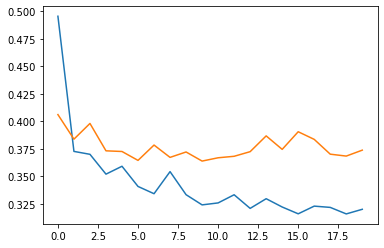

In [101]:
plt.plot(history2.history['loss'],label='Training')
plt.plot(history2.history['val_loss'],label='Validation')


## Testing

In [102]:
test_loss,test_accuracy = model.evaluate(test_inputs,test_outputs)

14/14 [==============================] - 0s 1ms/step - loss: 0.3065 - accuracy: 0.8434


In [111]:
print("Testing accuracy : {}% \nTesting loss : {}".format(round(test_accuracy *100,2),round(test_loss,2)))

Testing accuracy : 84.34% 
Testing loss : 0.31
